# Airline Customer Satisfaction

> (c) 2021 Travis Lloyd, Isabella Oakes, Lina Nguyen 
>
> An anlysis of Airline satisfaction
>


***
**Table of Contents**<br>
>[Data PreProcessing](#preproc)<br>
>[Models](#models)<br>
>[Results](#results)<br>

In [33]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

from dmba import classificationSummary

%matplotlib inline
DATA = Path('.').resolve().parent / 'data'

In [2]:
df = pd.read_csv(DATA / 'air_train.csv')
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


<a id="preproc"></a>
<br>
## Data Preprocessing


In [3]:
df = df.rename(columns={'Customer Type':'customer_type',
                   'Type of Travel':'travel_type',
                   'Flight Distance':'flight_dist',
                   'Inflight wifi service':'wifi_service',
                   'Departure/Arrival time convenient':'time_convenience',
                   'Ease of Online booking':'booking_diff',
                   'Gate location':'gate_loc',
                   'Food and drink':'food_drink',
                   'Online boarding':'online_boarding', 
                   'Seat comfort':'seat_comf',
                   'Inflight entertainment':'inflight_ent', 
                   'On-board service':'onboard_serv', 
                   'Leg room service':'legroom',
                   'Baggage handling':'baggage_care', 
                   'Checkin service':'checkin',
                   'Inflight service':'inflight_serv',
                   'Departure Delay in Minutes':'dept_delay', 
                   'Arrival Delay in Minutes':'arr_delay'
                  })

In [4]:
# Number of unique values
for column in df.columns:
    print(column, df[column].nunique())

Unnamed: 0 103904
id 103904
Gender 2
customer_type 2
Age 75
travel_type 2
Class 3
flight_dist 3802
wifi_service 6
time_convenience 6
booking_diff 6
gate_loc 6
food_drink 6
online_boarding 6
seat_comf 6
inflight_ent 6
onboard_serv 6
legroom 6
baggage_care 5
checkin 6
inflight_serv 6
Cleanliness 6
dept_delay 446
arr_delay 455
satisfaction 2


In [39]:
#Helper Functions

classes = ('Satisfied', 'Unsatisfied')

def check_na(df):
    if df.isna().sum().sum():
        print ('Missing values detected')
    else:
        print('No Missing Values Detected')

        #Function for printing model evaluation metrics
def stat_print(train_y, pred_cancel):
    print('Recall Score    : ',recall_score(train_y, pred_cancel, average='weighted'))
    print('Accuracy Score  : ',accuracy_score(train_y, pred_cancel))
    print('F1 Score        : ',f1_score(train_y,pred_cancel))
    print('Precision Score : ',precision_score(train_y,pred_cancel))
    
    
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y, model.predict(train_X), class_names=classes)
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred, class_names=classes)

In [6]:
check_na(df)

Missing values detected


In [7]:
## Checking for na values
df.isna().sum()

Unnamed: 0            0
id                    0
Gender                0
customer_type         0
Age                   0
travel_type           0
Class                 0
flight_dist           0
wifi_service          0
time_convenience      0
booking_diff          0
gate_loc              0
food_drink            0
online_boarding       0
seat_comf             0
inflight_ent          0
onboard_serv          0
legroom               0
baggage_care          0
checkin               0
inflight_serv         0
Cleanliness           0
dept_delay            0
arr_delay           310
satisfaction          0
dtype: int64

In [8]:
df.sort_values(by='dept_delay', ascending=False)

,Unnamed: 0,id,Gender,customer_type,Age,travel_type,Class,flight_dist,wifi_service,time_convenience,...,inflight_ent,onboard_serv,legroom,baggage_care,checkin,inflight_serv,Cleanliness,dept_delay,arr_delay,satisfaction
83741,83741,73471,Female,Loyal Customer,47,Personal Travel,Eco,1120,2,2,...,2,4,4,4,2,3,2,1592,1584.0,neutral or dissatisfied
6744,6744,69661,Male,Loyal Customer,32,Business travel,Business,2916,2,2,...,3,4,5,4,5,3,5,1305,1280.0,satisfied
61310,61310,4903,Male,Loyal Customer,49,Business travel,Business,1959,1,1,...,4,4,4,5,4,4,4,1017,1011.0,satisfied
72206,72206,78300,Male,Loyal Customer,30,Personal Travel,Eco,1598,1,4,...,5,3,4,4,1,4,1,978,970.0,neutral or dissatisfied
80182,80182,8345,Male,Loyal Customer,47,Business travel,Business,2187,4,5,...,5,4,5,5,4,4,4,933,920.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44435,44435,95245,Male,Loyal Customer,49,Personal Travel,Eco,189,3,1,...,1,1,3,3,4,4,1,0,0.0,neutral or dissatisfied
44434,44434,58151,Female,Loyal Customer,42,Business travel,Business,3239,5,5,...,4,4,5,4,5,4,4,0,34.0,satisfied
44432,44432,6253,Female,Loyal Customer,8,Personal Travel,Eco,413,2,5,...,5,2,3,4,4,2,5,0,0.0,neutral or dissatisfied
44431,44431,48424,Male,Loyal Customer,47,Business travel,Eco,819,4,2,...,5,1,5,4,5,1,5,0,0.0,satisfied


In [9]:
df['arr_delay'].fillna(value=df['dept_delay'] -5,inplace=True)

In [10]:
min_value = df['flight_dist'].min()
max_value = df['flight_dist'].max()
print(min_value)
print(max_value)

31
4983


In [11]:
bins = np.linspace(min_value,max_value,4)
bins.round(2)

array([  31.  , 1681.67, 3332.33, 4983.  ])

In [12]:
labels = ['short', 'medium', 'long']


In [13]:
df['flight_length'] = pd.cut(df['flight_dist'], bins=bins, labels=labels, include_lowest=True)

(array([76737., 21561.,  5606.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

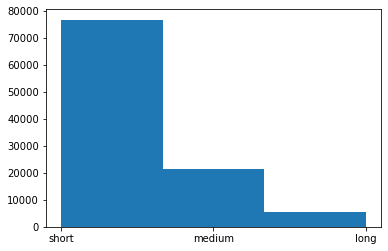

In [14]:
plt.hist(df['flight_length'], bins=3)


In [15]:
df.head(2)

,Unnamed: 0,id,Gender,customer_type,Age,travel_type,Class,flight_dist,wifi_service,time_convenience,...,onboard_serv,legroom,baggage_care,checkin,inflight_serv,Cleanliness,dept_delay,arr_delay,satisfaction,flight_length
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,4,3,4,4,5,5,25,18.0,neutral or dissatisfied,short
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,5,3,1,4,1,1,6.0,neutral or dissatisfied,short


In [16]:
## Creating dummy variable for Gender
# Male:0, Female:1
df.loc[df['Gender'] == 'Male', 'flight_dummy'] = 0
df.loc[df['Gender'] == 'Female', 'flight_dummy'] = 1

## Creating dummy variable for customer type
# disloyal:0, loyal:1
df.loc[df['customer_type'] == 'Loyal Customer', 'flight_dummy'] = 1
df.loc[df['customer_type'] == 'disloyal Customer', 'flight_dummy'] = 0

## Creating dummy variable for travel type
# personal:0, business:1
df.loc[df['travel_type'] == 'Business travel', 'flight_dummy'] = 1
df.loc[df['travel_type'] == 'Personal Travel', 'flight_dummy'] = 0


## Creating dummy variable for flight length
#1:short, 2:medium, 3:long
df.loc[df['flight_length'] == 'short', 'flight_dummy'] = 1
df.loc[df['flight_length'] == 'medium', 'flight_dummy'] = 2
df.loc[df['flight_length'] == 'long', 'flight_dummy'] = 3

## Creating dummy variable for Class
#1:Eco, 2:Eco Plus 3:Business
df.loc[df['Class'] == 'Eco', 'class_dummy'] = 1
df.loc[df['Class'] == 'Eco Plus', 'class_dummy'] = 2
df.loc[df['Class'] == 'Business', 'class_dummy'] = 3


## Creating dummy variable for satisfaction (1 for satisfied)
df.loc[df['satisfaction'] == 'neutral or dissatisfied', 'satisfaction_dummy'] = 0
df.loc[df['satisfaction'] == 'satisfied', 'satisfaction_dummy'] = 1


In [17]:
df = df.drop(columns=['travel_type','customer_type','flight_dist','flight_length','satisfaction','Class','Gender'])

df.head(30)

,Unnamed: 0,id,Age,wifi_service,time_convenience,booking_diff,gate_loc,food_drink,online_boarding,seat_comf,...,legroom,baggage_care,checkin,inflight_serv,Cleanliness,dept_delay,arr_delay,flight_dummy,class_dummy,satisfaction_dummy
0,0,70172,13,3,4,3,1,5,3,5,...,3,4,4,5,5,25,18.0,1.0,2.0,0.0
1,1,5047,25,3,2,3,3,1,3,1,...,5,3,1,4,1,1,6.0,1.0,3.0,0.0
2,2,110028,26,2,2,2,2,5,5,5,...,3,4,4,4,5,0,0.0,1.0,3.0,1.0
3,3,24026,25,2,5,5,5,2,2,2,...,5,3,1,4,2,11,9.0,1.0,3.0,0.0
4,4,119299,61,3,3,3,3,4,5,5,...,4,4,3,3,3,0,0.0,1.0,3.0,1.0
5,5,111157,26,3,4,2,1,1,2,1,...,4,4,4,4,1,0,0.0,1.0,1.0,0.0
6,6,82113,47,2,4,2,3,2,2,2,...,3,4,3,5,2,9,23.0,1.0,1.0,0.0
7,7,96462,52,4,3,4,4,5,5,5,...,5,5,4,5,4,4,0.0,2.0,3.0,1.0
8,8,79485,41,1,2,2,2,4,3,3,...,2,1,4,1,2,0,0.0,1.0,3.0,0.0
9,9,65725,20,3,3,3,4,2,3,3,...,3,4,4,3,2,0,0.0,1.0,1.0,0.0


In [18]:
df.corr()

,Unnamed: 0,id,Age,wifi_service,time_convenience,booking_diff,gate_loc,food_drink,online_boarding,seat_comf,...,legroom,baggage_care,checkin,inflight_serv,Cleanliness,dept_delay,arr_delay,flight_dummy,class_dummy,satisfaction_dummy
Unnamed: 0,1.000000,0.002991,0.004786,-0.002490,0.000739,0.001913,0.005073,-0.002162,0.001002,0.000044,...,0.004052,-0.000526,-0.004321,-0.000134,-0.001117,-0.000045,0.000584,0.002144,0.000798,-0.004731
id,0.002991,1.000000,0.022857,-0.021276,-0.002110,0.014163,-0.000606,0.001063,0.055477,0.052903,...,0.044634,0.074940,0.079273,0.079346,0.024965,-0.019546,-0.037310,0.064137,0.095698,0.013734
Age,0.004786,0.022857,1.000000,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,...,0.040583,-0.047529,0.035482,-0.049427,0.053611,-0.010152,-0.012133,0.114496,0.140565,0.137167
wifi_service,-0.002490,-0.021276,0.017859,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,...,0.160473,0.120923,0.043193,0.110441,0.132698,-0.017402,-0.019035,0.004179,0.036279,0.284245
time_convenience,0.000739,-0.002110,0.038125,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,...,0.012441,0.072126,0.093333,0.073318,0.014292,0.001005,-0.000663,-0.031174,-0.092788,-0.051601
booking_diff,0.001913,0.014163,0.024842,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,...,0.107601,0.038762,0.011081,0.035272,0.016179,-0.006371,-0.008045,0.054428,0.106391,0.171705
gate_loc,0.005073,-0.000606,-0.001330,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,...,-0.005873,0.002313,-0.035427,0.001681,-0.003830,0.005467,0.005097,0.007898,0.004150,0.000682
food_drink,-0.002162,0.001063,0.023000,0.134718,0.004906,0.031873,-0.001159,1.000000,0.234468,0.574556,...,0.032498,0.034746,0.087299,0.033993,0.657760,-0.029926,-0.032462,0.052659,0.085908,0.209936
online_boarding,0.001002,0.055477,0.208939,0.456970,0.070119,0.404074,0.001688,0.234468,1.000000,0.420211,...,0.123950,0.083280,0.204462,0.074573,0.331517,-0.018982,-0.022382,0.199445,0.322924,0.503557
seat_comf,0.000044,0.052903,0.160277,0.122658,0.011344,0.030014,0.003669,0.574556,0.420211,1.000000,...,0.105559,0.074542,0.191854,0.069218,0.678534,-0.027898,-0.030420,0.150595,0.227444,0.349459


<AxesSubplot:>

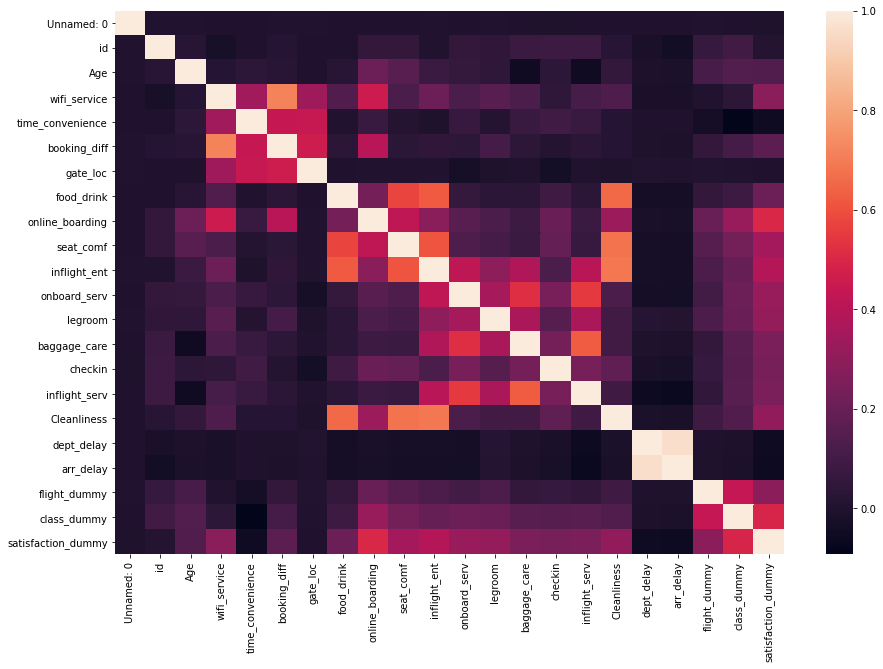

In [19]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr())


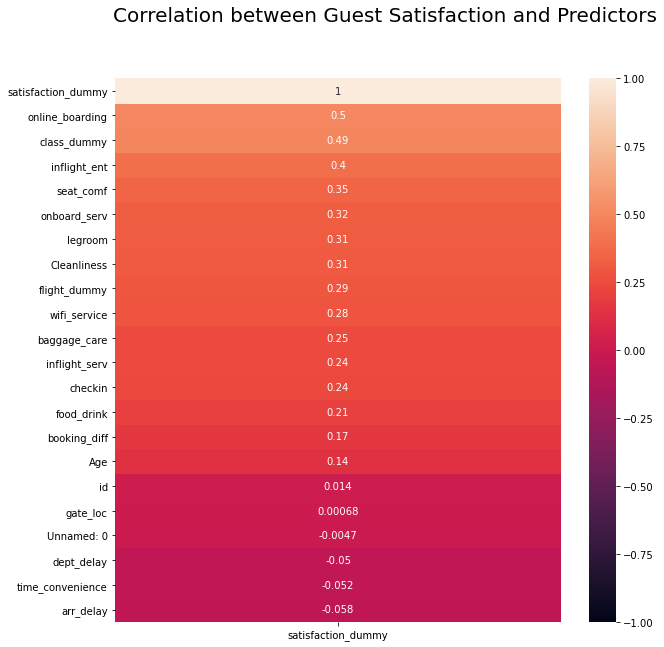

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Correlation between Guest Satisfaction and Predictors',fontsize=20)
ax=sns.heatmap(df.corr()[['satisfaction_dummy']].sort_values("satisfaction_dummy"),vmax=1, vmin=-1, cmap="rocket", annot=True, ax=ax);
ax.invert_yaxis()

In [21]:
df.columns


Index(['Unnamed: 0', 'id', 'Age', 'wifi_service', 'time_convenience',
       'booking_diff', 'gate_loc', 'food_drink', 'online_boarding',
       'seat_comf', 'inflight_ent', 'onboard_serv', 'legroom', 'baggage_care',
       'checkin', 'inflight_serv', 'Cleanliness', 'dept_delay', 'arr_delay',
       'flight_dummy', 'class_dummy', 'satisfaction_dummy'],
      dtype='object')

In [22]:
predictors = ['Age', 'wifi_service','booking_diff', 'food_drink', 'online_boarding','seat_comf',
              'inflight_ent', 'onboard_serv', 'legroom', 'baggage_care', 'checkin', 'inflight_serv',
              'Cleanliness','flight_dummy', 'class_dummy']
outcome = ['satisfaction_dummy']


In [28]:
X = df[predictors]
y = df[outcome]

In [24]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y,train_size=.7,random_state=1)
train_X.shape, valid_X.shape

((72732, 15), (31172, 15))

<a id="models"></a>
<br>
# Classification Models

### _Logistic Regression Model_

In [45]:
logit = LogisticRegressionCV(penalty='l2', solver='saga', cv=5, max_iter=110000).fit(train_X, train_y.values.ravel())

In [46]:
logit_confusion = confusionMatrices(logit, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.8428)

            Prediction
     Actual   Satisfied Unsatisfied
  Satisfied       36150        5037
Unsatisfied        6399       25146
Logistic regression - validation results
Confusion Matrix (Accuracy 0.8460)

            Prediction
     Actual   Satisfied Unsatisfied
  Satisfied       15596        2096
Unsatisfied        2703       10777


### _Decision Tree_

In [41]:
dtree = DecisionTreeClassifier().fit(train_X, train_y)
tree_confusion = confusionMatrices(dtree, 'Decision Tree')

Decision Tree - training results
Confusion Matrix (Accuracy 0.9998)

            Prediction
     Actual   Satisfied Unsatisfied
  Satisfied       41186           1
Unsatisfied          16       31529
Decision Tree - validation results
Confusion Matrix (Accuracy 0.9236)

            Prediction
     Actual   Satisfied Unsatisfied
  Satisfied       16424        1268
Unsatisfied        1113       12367


In [43]:
rf = RandomForestClassifier(n_estimators=100).fit(train_X, train_y.values.ravel())

In [44]:
forest_confusion = confusionMatrices(rf, 'Random Forest')

Random Forest - training results
Confusion Matrix (Accuracy 0.9998)

            Prediction
     Actual   Satisfied Unsatisfied
  Satisfied       41178           9
Unsatisfied           8       31537
Random Forest - validation results
Confusion Matrix (Accuracy 0.9482)

            Prediction
     Actual   Satisfied Unsatisfied
  Satisfied       17086         606
Unsatisfied        1010       12470


<a id="results"></a>
<br>
# Results